# EDA & Preprocessing
## Backorer Prediction from Kaggle

## Context

Part backorders is a common supply chain problem. Working to identify parts at risk of backorder before the event occurs so the business has time to react.

### Content

Training data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

sku - Random ID for the product

national_inv - Current inventory level for the part

lead_time - Transit time for product (if available)

in_transit_qty - Amount of product in transit from source

forecast_3_month - Forecast sales for the next 3 months

forecast_6_month - Forecast sales for the next 6 months

forecast_9_month - Forecast sales for the next 9 months

sales_1_month - Sales quantity for the prior 1 month time period

sales_3_month - Sales quantity for the prior 3 month time period

sales_6_month - Sales quantity for the prior 6 month time period

sales_9_month - Sales quantity for the prior 9 month time period

min_bank - Minimum recommend amount to stock

potential_issue - Source issue for part identified

pieces_past_due - Parts overdue from source

perf_6_month_avg - Source performance for prior 6 month period

perf_12_month_avg - Source performance for prior 12 month period

local_bo_qty - Amount of stock orders overdue

deck_risk - Part risk flag

oe_constraint - Part risk flag

ppap_risk - Part risk flag

stop_auto_buy - Part risk flag

rev_stop - Part risk flag

went_on_backorder - Product actually went on backorder. This is the target value.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

C:\Python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load data

In [2]:
train = pd.read_csv("./data/Kaggle_Training_Dataset_v2.csv")
test = pd.read_csv("./data/Kaggle_Test_Dataset_v2.csv")

C:\Python36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
sku                  1687861 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null object
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null object
oe_constraint        1687860 non-null object
ppap_risk        

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242076 entries, 0 to 242075
Data columns (total 23 columns):
sku                  242076 non-null object
national_inv         242075 non-null float64
lead_time            227351 non-null float64
in_transit_qty       242075 non-null float64
forecast_3_month     242075 non-null float64
forecast_6_month     242075 non-null float64
forecast_9_month     242075 non-null float64
sales_1_month        242075 non-null float64
sales_3_month        242075 non-null float64
sales_6_month        242075 non-null float64
sales_9_month        242075 non-null float64
min_bank             242075 non-null float64
potential_issue      242075 non-null object
pieces_past_due      242075 non-null float64
perf_6_month_avg     242075 non-null float64
perf_12_month_avg    242075 non-null float64
local_bo_qty         242075 non-null float64
deck_risk            242075 non-null object
oe_constraint        242075 non-null object
ppap_risk            242075 non-null o

In [5]:
train.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [6]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Columns: 23 entries, sku to went_on_backorder
dtypes: float64(15), object(8)
memory usage: 296.2+ MB


In [7]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242076 entries, 0 to 242075
Columns: 23 entries, sku to went_on_backorder
dtypes: float64(15), object(8)
memory usage: 42.5+ MB


In [8]:
len(test.sku)/len(train.sku)

0.14342176281103716

In [9]:
train.isnull().sum()

sku                       0
national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

In [10]:
test.isnull().sum()

sku                      0
national_inv             1
lead_time            14725
in_transit_qty           1
forecast_3_month         1
forecast_6_month         1
forecast_9_month         1
sales_1_month            1
sales_3_month            1
sales_6_month            1
sales_9_month            1
min_bank                 1
potential_issue          1
pieces_past_due          1
perf_6_month_avg         1
perf_12_month_avg        1
local_bo_qty             1
deck_risk                1
oe_constraint            1
ppap_risk                1
stop_auto_buy            1
rev_stop                 1
went_on_backorder        1
dtype: int64

In [11]:
train.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,...,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242075,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Interim check  01
- "sku" is stock keeping unit, so it is just product ID.
    - "sku" can be used as index
- found that dataset is large and only have dtype of float64 and object
    - seperate float columns and object columns
    - ~~may can change into float32~~
- test set is 14% compare to train set
    - may too small
    - maybe can make 2 validation sets
- found that dataset needs imputation of missing values
    - especially "lead_time"

In [13]:
train = train.set_index('sku')
test = test.set_index('sku')
train.tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,...,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,...,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,...,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
float_cols = []
object_cols = []

In [15]:
# checking for max float number 
## may can change dtype from float64 to float32 for memory saving, later

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        float_cols.append(c)
        print(max(train[c]), '\t', c)
        
print()        
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        print(max(test[c]), '\t', c)

print()
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == object:
        object_cols.append(c)
        print(c)

12334404.0 	 national_inv
nan 	 lead_time
489408.0 	 in_transit_qty
1427612.0 	 forecast_3_month
2461360.0 	 forecast_6_month
3777304.0 	 forecast_9_month
741774.0 	 sales_1_month
1105478.0 	 sales_3_month
2146625.0 	 sales_6_month
3205172.0 	 sales_9_month
313319.0 	 min_bank
146496.0 	 pieces_past_due
1.0 	 perf_6_month_avg
1.0 	 perf_12_month_avg
12530.0 	 local_bo_qty

12145792.0 	 national_inv
nan 	 lead_time
265272.0 	 in_transit_qty
1510592.0 	 forecast_3_month
2157024.0 	 forecast_6_month
3162260.0 	 forecast_9_month
349620.0 	 sales_1_month
1099852.0 	 sales_3_month
2103389.0 	 sales_6_month
3195211.0 	 sales_9_month
303713.0 	 min_bank
79964.0 	 pieces_past_due
1.0 	 perf_6_month_avg
1.0 	 perf_12_month_avg
6232.0 	 local_bo_qty

potential_issue
deck_risk
oe_constraint
ppap_risk
stop_auto_buy
rev_stop
went_on_backorder


In [16]:
print(float_cols, '\n', '\n', object_cols)

['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty'] 
 
 ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


### ~~Convert dtype float64 to float32~~
- ~~To reduce memory usage, converted data type~~

In [17]:
train[float_cols].tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
sku,,,,,,,,,,,,,,,
1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,0.0,-99.00,-99.00,1.0
1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,0.0,0.86,0.84,1.0
1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,0.0,0.86,0.84,6.0
1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,0.0,0.73,0.78,1.0
(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
train[object_cols].tail()

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,
1373987,No,No,No,No,Yes,No,No
1524346,No,Yes,No,No,No,No,Yes
1439563,No,No,No,No,Yes,No,No
1502009,No,No,No,No,Yes,No,No
(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
test[float_cols].tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
sku,,,,,,,,,,,,,,,
3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.48,0.48,0.0
3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.48,0.48,0.0
3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.48,0.48,0.0
3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,0.0,0.48,0.48,0.0
(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
test[object_cols].tail()

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,
3526988,No,Yes,No,No,Yes,No,No
3526989,No,Yes,No,No,Yes,No,No
3526990,No,Yes,No,No,Yes,No,No
3526991,No,Yes,No,No,Yes,No,No
(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

### Imputing missing values
- "lead_time" and "perf_month_avg" have missing values. (NaN or -99.00)
    - use imputer to fill this values with a new value.
    - usually use mean or median. But have to decide 
- last data records from train & test have 'NaN' value, which is empty row. 
    - will drop it

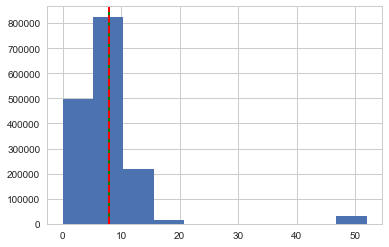

Median of lead_time : 8.0
Mean of lead_time : 7.872267035168343


In [21]:
plt.figure(1)
train.lead_time.hist()
plt.axvline(train.lead_time.median(), 
            color="green", 
            linewidth=2.0)
plt.axvline(train.lead_time.mean(), 
            color="red", 
            linestyle='dashed', 
            linewidth=2.0)
plt.show()
print("Median of lead_time : {}".format(train.lead_time.median()))
print("Mean of lead_time : {}".format(train.lead_time.mean()))

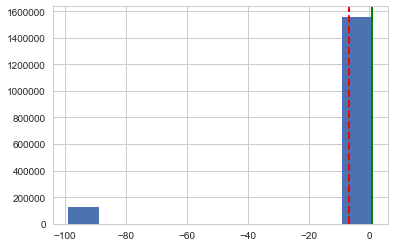

Median of perf_6_month_avg : 0.82
Mean of perf_6_month_avg : -6.8720588378183045


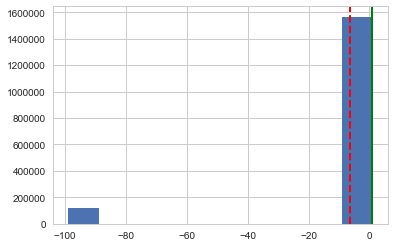

Median of perf_12_month_avg : 0.81
Mean of perf_12_month_avg : -6.437946743213299


In [22]:
plt.figure(1)
train.perf_6_month_avg.hist()
plt.axvline(train.perf_6_month_avg.median(), 
            color="green", 
            linewidth=2.0)
plt.axvline(train.perf_6_month_avg.mean(), 
            color="red", 
            linestyle='dashed', 
            linewidth=2.0)
plt.show()
print("Median of perf_6_month_avg : {}".format(train.perf_6_month_avg.median()))
print("Mean of perf_6_month_avg : {}".format(train.perf_6_month_avg.mean()))

plt.figure(2)
train.perf_12_month_avg.hist()
plt.axvline(train.perf_12_month_avg.median(), 
            color="green", 
            linewidth=2.0)
plt.axvline(train.perf_12_month_avg.mean(), 
            color="red", 
            linestyle='dashed', 
            linewidth=2.0)
plt.show()
print("Median of perf_12_month_avg : {}".format(train.perf_12_month_avg.median()))
print("Mean of perf_12_month_avg : {}".format(train.perf_12_month_avg.mean()))

In [23]:
# choose median to imput missing values in 'lead_time'
from sklearn.preprocessing import Imputer
train['lead_time'] = Imputer(strategy='median').fit_transform(
    train['lead_time'].values.reshape(-1,1))

## test dataset's lead_time median is same with train set
test['lead_time'] = Imputer(strategy='median').fit_transform(
    test['lead_time'].values.reshape(-1,1))


# drop NaN values
train = train.dropna()
test = test.dropna()


# choose mean to imput missing values in 'perf_month_avg'
for col in ['perf_6_month_avg', 'perf_12_month_avg']:
        train[col] = Imputer(missing_values=-99).fit_transform(
                                    train[col].values.reshape(-1, 1))

## imput values in test set with same values in train set
f6 = lambda x: -6.8720588378183045 if x == -99 else x
test["perf_6_month_avg"] = test["perf_6_month_avg"].apply(f6)
f12 = lambda x: -6.437946743213299 if x == -99 else x
test["perf_12_month_avg"] = test["perf_12_month_avg"].apply(f12)

### Convert to binaries
- object dtype columns (except "sku") have 'Yes' or 'No'
- look if it okay to convert into '1' and '0'

In [24]:
for i in object_cols:
    train[i] = (train[i] == 'Yes').astype(int)
    test[i] = (test[i] == 'Yes').astype(int)
train[object_cols].tail()

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,
1407754,0,1,0,0,1,0,0
1373987,0,0,0,0,1,0,0
1524346,0,1,0,0,0,0,1
1439563,0,0,0,0,1,0,0
1502009,0,0,0,0,1,0,0


<br>
<br>

### Analyse target variable
- the target variable is "went_on_backorder".
- whether item is went on backorder or not. 
- classes are consist of 0 and 1

#### Train set

In [25]:
print("Items not on backorder, Class 0: {}".format(train.went_on_backorder.value_counts()[0]))
print("Items went on backorder, Class 1: {}".format(train.went_on_backorder.value_counts()[1]))

train.went_on_backorder.value_counts()

Items not on backorder, Class 0: 1676567
Items went on backorder, Class 1: 11293


0    1676567
1      11293
Name: went_on_backorder, dtype: int64

Proportion of items not on backorder: 99.33092792056213%
Proportion of items went on backorder: 0.6690720794378681%


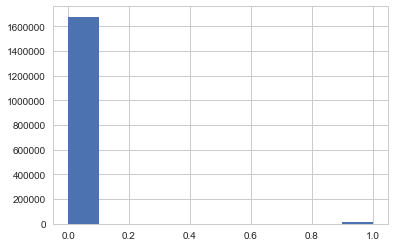

In [26]:
print("Proportion of items not on backorder: {}%".format(100*train.went_on_backorder.value_counts()[0]/len(train.went_on_backorder)))
print("Proportion of items went on backorder: {}%".format(100*train.went_on_backorder.value_counts()[1]/len(train.went_on_backorder)))
train.went_on_backorder.hist()
plt.show()

#### Test set

In [27]:
print("Items not on backorder, Class 0: {}".format(test.went_on_backorder.value_counts()[0]))
print("Items went on backorder, Class 1: {}".format(test.went_on_backorder.value_counts()[1]))

test.went_on_backorder.value_counts()

Items not on backorder, Class 0: 239387
Items went on backorder, Class 1: 2688


0    239387
1      2688
Name: went_on_backorder, dtype: int64

Proportion of items not on backorder: 98.88960033047609%
Proportion of items went on backorder: 1.1103996695239078%


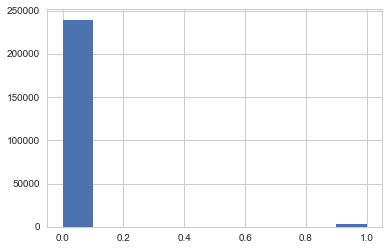

In [28]:
print("Proportion of items not on backorder: {}%".format(100*test.went_on_backorder.value_counts()[0]/len(test.went_on_backorder)))
print("Proportion of items went on backorder: {}%".format(100*test.went_on_backorder.value_counts()[1]/len(test.went_on_backorder)))
test.went_on_backorder.hist()
plt.show()

Both train set and test set have very small proportion of backordered items.

Have to consider whether use supervised learning OR statistical approach(ex. gausian, anomaly detection, etc).

### Visualization
- visualization of variables

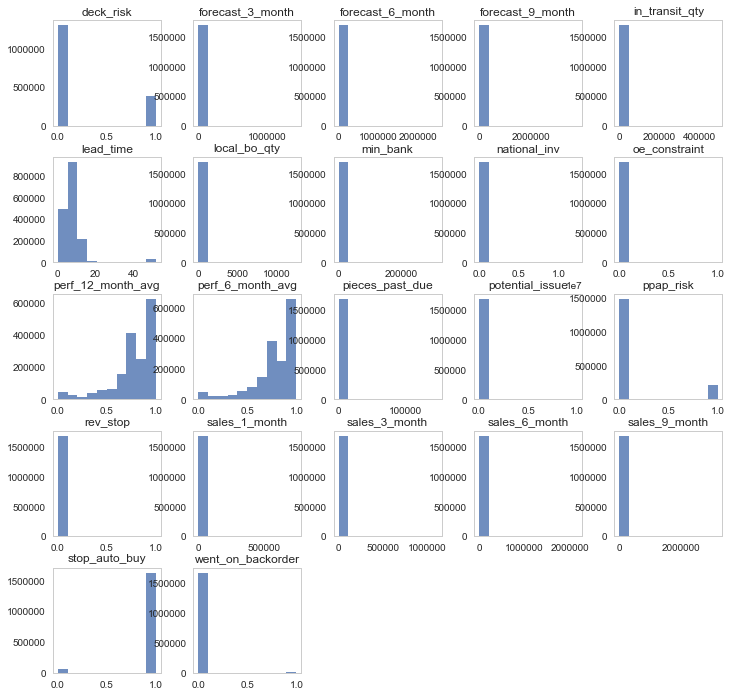

In [29]:
train.hist(figsize=(12,12), alpha=0.8, grid=False)
plt.show()

- even visualized, it is not easy to look.
- may need normalizatioin on quantitative variables
    - 'national_inv', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month',  'forecast_9_month', 'min_bank', 'local_bo_qty', 'pieces_past_due', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month'
- 'perf_month_avg' variables are scaled distribution, so no need normalization
- 'lead_time' is based on time. So not sure whether normalize or scale
    - may just convert to log or sqrt

### Merging train and test datasets before normalization

In [30]:
df = pd.concat([train, test])

In [31]:
print(df.shape)
df.tail()

(1929935, 22)


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
3526987,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,1,0,0,1,0,0
3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,1,0,0,1,0,0
3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,1,0,0,1,0,0
3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,1,0,0,1,0,0
3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,...,0.0,0.48,0.48,0.0,1,0,0,1,0,0


In [32]:
print(pd.DataFrame(df, index = train.index).shape)
print(pd.DataFrame(df, index = test.index).shape)

(1687860, 22)
(242075, 22)


### Normalization
- quantities of each items are various. 
- need to be normalized to look data easily

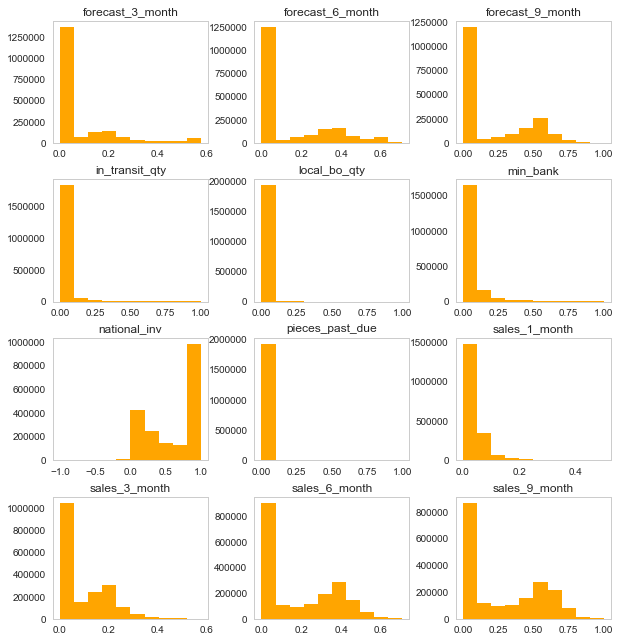

In [33]:
qty_cols = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
            'forecast_6_month', 'forecast_9_month', 'min_bank', 
            'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
            'sales_3_month', 'sales_6_month', 'sales_9_month']

from sklearn.preprocessing import normalize
df[qty_cols] = normalize(df[qty_cols], axis=1)
df[qty_cols].hist(figsize=(10,11), color='orange', grid=False)
plt.show()

There are too many 0 values in "sales_month" & "forecast_month" variables.
May this means that some items have no past sales or forecast.
And maybe these items also take large part of "national_inv".

In [34]:
train_1 = pd.DataFrame(df, index = train.index)
test_1 = pd.DataFrame(df, index = test.index)

### Obsolete inventory
There are so many items with 0 (no past sales or forecast).
    - found out that these kind of items are defined as obsolete inventory or obsolete parts.
    - which is materials that have no transactions in the last months, so have no forecast.
As a solution of this problem, will select only **ACTIVE** items, and use as alternative
- items selected based on the following rule: **"forecast_3_month" > 0 AND "sales_9_month" > 0**

In [35]:
actives = train_1.loc[(train_1["forecast_3_month"]>0)&(train_1["sales_9_month"]>0)]
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_1.went_on_backorder)))
print('Reduced dataset shape {}'.format(Counter(actives.went_on_backorder)))
print('Class 0 reduction: %.2f%%' % (100*(1 - Counter(actives.went_on_backorder)[0]/Counter(train_1.went_on_backorder)[0])))
print('Class 1 reduction: %.2f%%' % (100*(1 - Counter(actives.went_on_backorder)[1]/Counter(train_1.went_on_backorder)[1])))

Original dataset shape Counter({0: 1676567, 1: 11293})
Reduced dataset shape Counter({0: 423032, 1: 8414})
Class 0 reduction: 74.77%
Class 1 reduction: 25.49%


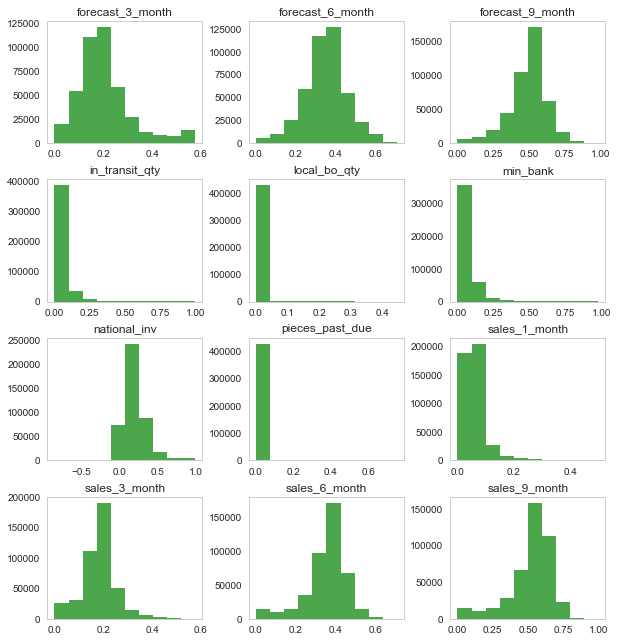

In [36]:
actives[qty_cols].hist(figsize=(10,11), alpha=0.7, color='green', grid=False)
plt.show()

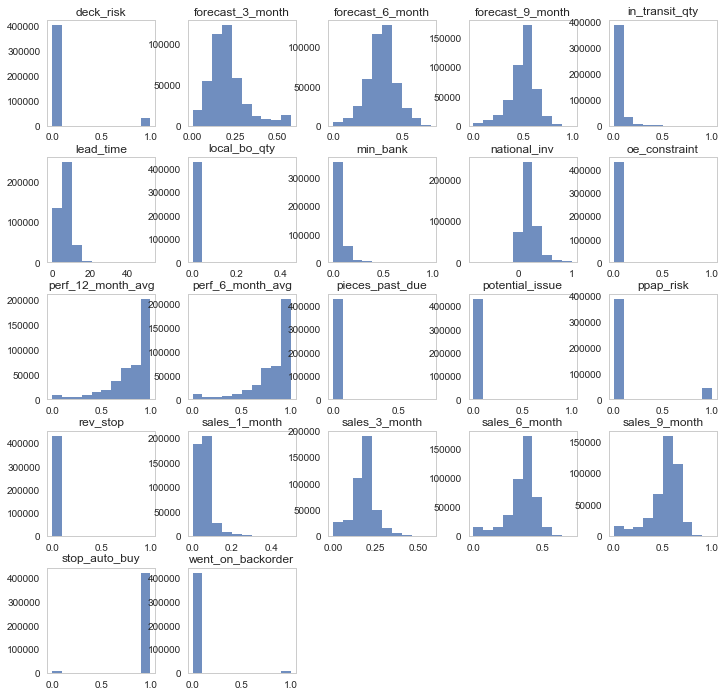

In [37]:
actives.hist(figsize=(12,12), alpha=0.8, grid=False)
plt.show()

This approach reduced the original dominant classes by 75%, while just loosing 25% of the class 1.

But could use a less aggressive approach, adopting the rule **"forecast_3_month > 0" OR "sales_9_month > 0"**

In [38]:
actives2 = train_1.loc[(train_1["forecast_3_month"]>0)|(train_1["sales_9_month"]>0)]
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_1.went_on_backorder)))
print('Reduced dataset shape {}'.format(Counter(actives2.went_on_backorder)))
print('Class 0 reduction: %.2f%%' % (100*(1 - Counter(actives2.went_on_backorder)[0]/Counter(train_1.went_on_backorder)[0])))
print('Class 1 reduction: %.2f%%' % (100*(1 - Counter(actives2.went_on_backorder)[1]/Counter(train_1.went_on_backorder)[1])))

Original dataset shape Counter({0: 1676567, 1: 11293})
Reduced dataset shape Counter({0: 1169554, 1: 11004})
Class 0 reduction: 30.24%
Class 1 reduction: 2.56%


Now the reduction in dominant class is 15x higher than in the class 1.

Using this may save some computing time and also presenting a cleaner dataset for the predictive model.

May use this rule or not in model.

<br>

### PCA, dimention reduction

In [39]:
from sklearn.decomposition import PCA

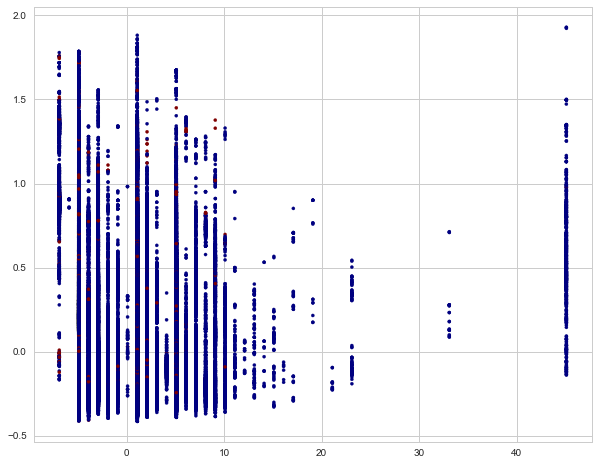

In [43]:
# n_components = 2

pca1 = PCA(2).fit(actives.iloc[:,:-1])
X1 = pca1.transform(actives.iloc[:,:-1])
plt.figure(figsize=(10,8))
plt.scatter(X1[:, 0], X1[:, 1], c=actives.went_on_backorder, s=10, cmap=plt.cm.jet)
plt.show()

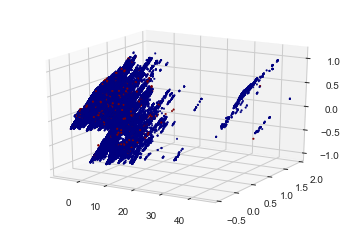

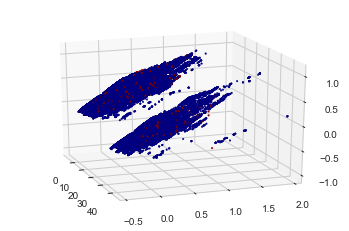

In [52]:
# n_components = 3

X2 = PCA(3).fit_transform(actives.iloc[:,:-1])

from mpl_toolkits.mplot3d import Axes3D

def plot_pca(azim):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d');
    ax.scatter(X2[:,0], X2[:,1], X2[:,2], c=actives.went_on_backorder, s=3, cmap=plt.cm.jet, alpha=1)
    ax.view_init(20, azim)

plot_pca(-60)
plot_pca(-20)
plt.show()

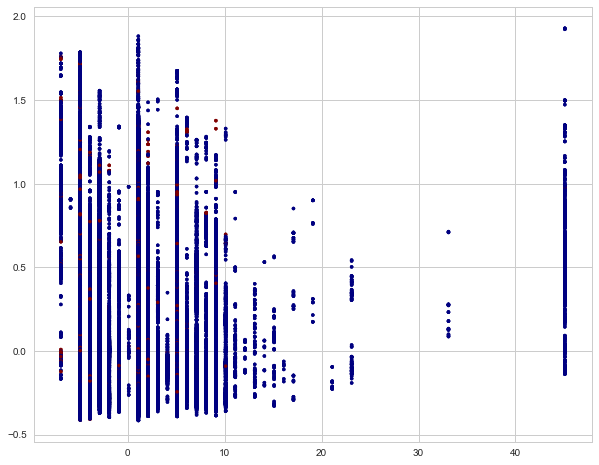

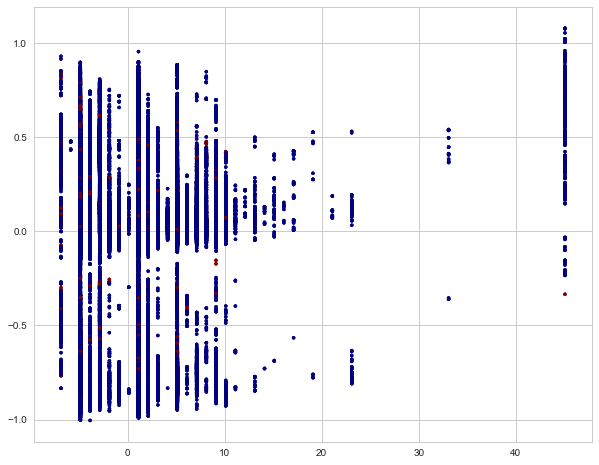

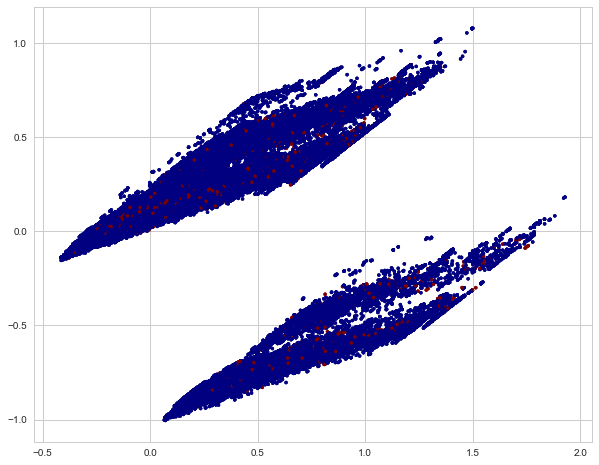

In [54]:
figsize=(10,8)
plt.figure(1, figsize=figsize)
plt.scatter(X2[:, 0], X2[:, 1], c=actives.went_on_backorder, s=10, cmap=plt.cm.jet)

plt.figure(2, figsize=figsize)
plt.scatter(X2[:, 0], X2[:, 2], c=actives.went_on_backorder, s=10, cmap=plt.cm.jet)

plt.figure(3, figsize=figsize)
plt.scatter(X2[:, 1], X2[:, 2], c=actives.went_on_backorder, s=10, cmap=plt.cm.jet)

plt.show()

<br>

#### Serialize data and save in file
- serialize dataframe and save into file
- to use for modeling

<br>

### Some result from EDA
Through exploratory data analysis with plotting data.

Found out some useful insight about data.
- between "national_inv" and "local_bo_qty" show some relation.
- no "went_on_backorder" items have "rev_stop" issue, which means those are only in class 0

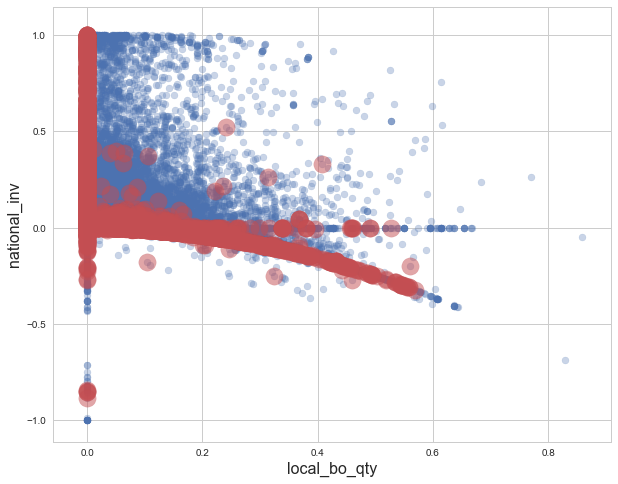

In [58]:
def plotData(myX, x, y, figsize=(10,8)):
    plt.figure(figsize=figsize)
    plt.scatter(np.sqrt(myX.iloc[:,x]),(myX.iloc[:,y]), alpha=0.3)
    plt.scatter(
        np.sqrt(actives2.loc[actives2['went_on_backorder']==1].iloc[:,x]),
        (actives2.loc[actives2['went_on_backorder']==1].iloc[:,y]),
        s=300, c="r", alpha=0.5
    )
    plt.xlabel('{}'.format(myX.columns[x]),fontsize=16)
    plt.ylabel('{}'.format(myX.columns[y]),fontsize=16)
    plt.grid(True)
plotData(actives2, 15, 0)
plt.show()

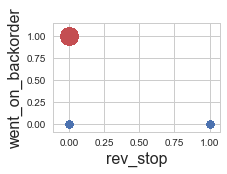

In [60]:
plotData(train, 20, 21, figsize=(3,2))
plt.show()